In [7]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.ensemble import VotingRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'dataset_corrected/'
x1_train = pd.read_csv(path+'c_data_x1_train.csv')
x2_train = pd.read_csv(path+'c_data_x2_train.csv')
y_train = pd.read_csv(path+'c_data_f1_train.csv')
y_test = pd.read_csv(path+'c_data_f1_test.csv')
x1_test = pd.read_csv(path+'c_data_x1_test.csv')
x2_test = pd.read_csv(path+'c_data_x2_test.csv')

fv1_train = pd.read_csv(path+'c_Filvel_x1_train.csv')
fv1_test = pd.read_csv(path+'c_Filvel_x1_test.csv')
fv2_train = pd.read_csv(path+'c_Filvel_x2_train.csv')
fv2_test = pd.read_csv(path+'c_Filvel_x2_test.csv')

v1_train = pd.read_csv(path+'c_vel_x1_train.csv')
v1_test = pd.read_csv(path+'c_vel_x1_test.csv')
v2_train = pd.read_csv(path+'c_vel_x2_train.csv')
v2_test = pd.read_csv(path+'c_vel_x2_test.csv')


In [3]:
X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train,fv1_train,fv2_train,v1_train,v2_train),axis=1),columns = ['p1','p2','fv1','fv2','v1','v2'])
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test,fv1_test,fv2_test,v1_test,v2_test),axis=1),columns = ['p1','p2','fv1','fv2','v1','v2'])
#y_train, y_test = np.array(y_train),np.array(y_test)
X_train.head()

,p1,p2,fv1,fv2,v1,v2
0,-0.0000,-0.0000,0.000000,0.000000,0.0000,0.0000
1,-0.0159,-0.0000,-0.001160,0.000000,-0.0159,0.0000
2,-0.0159,0.0171,-0.002151,0.001248,0.0000,0.0171
3,-0.0159,0.0171,-0.001837,0.002313,0.0000,0.0000
4,-0.0000,0.0329,-0.000409,0.003128,0.0159,0.0158


In [4]:
from scipy import *
from scipy.linalg import norm, pinv
import math

from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y



Time taken by RBF Model:  0:01:33.564694
Root mean square error of RBF Model:  0.046355054677768626
Minimum Error = [2.17167381e-06]
Maximum Error = [0.74095009]
Median Value of Error = [0.02026402]


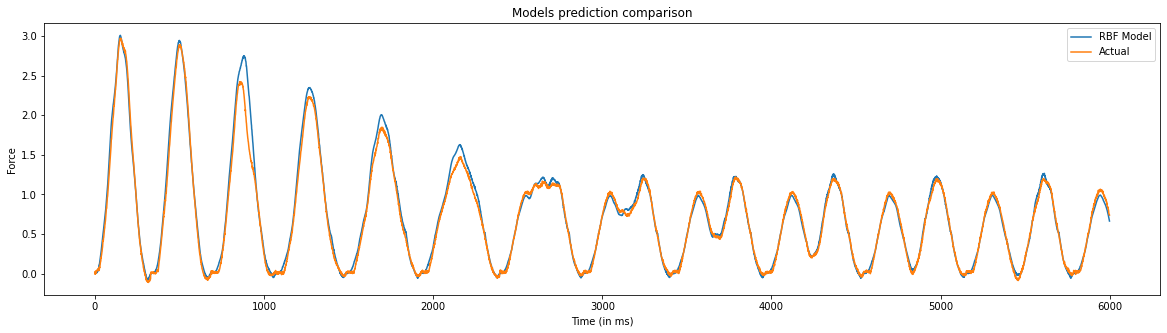

In [5]:
x_train,x_test = np.array(X_train),np.array(X_test)

# RBF MODEL with k = 100
rbf = RBF(6, 100, 1)
t1 = datetime.now()
rbf.train(x_train, y_train)
t2 = datetime.now()
    
print('\n\nTime taken by RBF Model: ',t2-t1)
y1_pred = rbf.test(x_test)
y2 = y1_pred
print('Root mean square error of RBF Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
error5 = []
for i in range(len(y_test)):
    error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
print('Minimum Error =',min(error5))
print('Maximum Error =',max(error5))
error6 = sorted(error5)
print('Median Value of Error =',error6[len(error5)//2])
    
plt.figure(figsize=(20,5))
plt.plot(list(range(6000)),y2[:6000], label = 'RBF Model')
plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('Models prediction comparison')
plt.show()
    

In [8]:
cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x_train,y_train)
t2 = datetime.now()

Learning rate set to 0.086822
0:	learn: 0.9241095	total: 57.2ms	remaining: 57.2s
1:	learn: 0.8487647	total: 64.8ms	remaining: 32.3s
2:	learn: 0.7790980	total: 71ms	remaining: 23.6s
3:	learn: 0.7158351	total: 75.9ms	remaining: 18.9s
4:	learn: 0.6579791	total: 80.3ms	remaining: 16s
5:	learn: 0.6047179	total: 84.8ms	remaining: 14s
6:	learn: 0.5558452	total: 89.2ms	remaining: 12.7s
7:	learn: 0.5112268	total: 93.6ms	remaining: 11.6s
8:	learn: 0.4705963	total: 98.4ms	remaining: 10.8s
9:	learn: 0.4339483	total: 103ms	remaining: 10.2s
10:	learn: 0.4002370	total: 108ms	remaining: 9.71s
11:	learn: 0.3697315	total: 113ms	remaining: 9.28s
12:	learn: 0.3415127	total: 118ms	remaining: 8.94s
13:	learn: 0.3160719	total: 122ms	remaining: 8.62s
14:	learn: 0.2920382	total: 127ms	remaining: 8.34s
15:	learn: 0.2703743	total: 132ms	remaining: 8.11s
16:	learn: 0.2505343	total: 137ms	remaining: 7.9s
17:	learn: 0.2324233	total: 141ms	remaining: 7.71s
18:	learn: 0.2158463	total: 146ms	remaining: 7.53s
19:	learn

Time taken by Cat Boosting: 0:00:05.114386
Root mean square error of Cat Boost Model:  0.042672113761221916


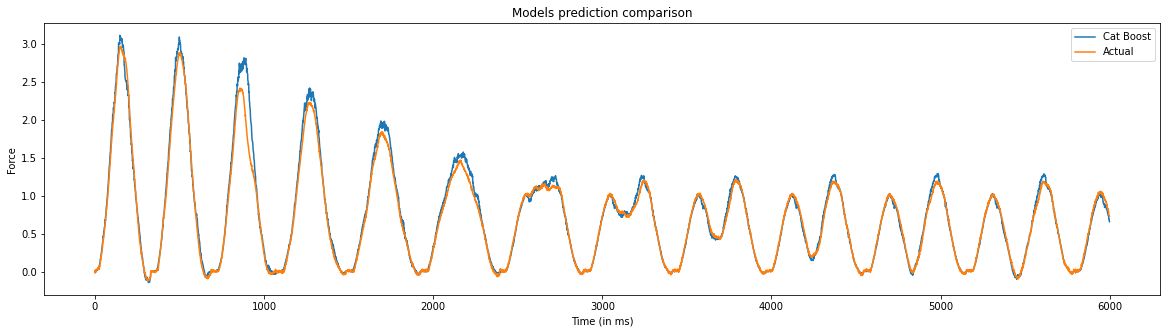

In [9]:
print('Time taken by Cat Boosting:',t2-t1)

y_pred = cat.predict(x_test)
print('Root mean square error of Cat Boost Model: ',sqrt(mean_squared_error(y_test,y_pred)))

plt.figure(figsize=(20,5))
plt.plot(list(range(6000)),y_pred[:6000], label = 'Cat Boost')
plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('Models prediction comparison')
plt.show()



Time taken by SVR Model:  0:00:43.642371
Root mean square error of SVR Model:  0.05196636439519236
Minimum Error = 1.398485420800455e-06
Maximum Error = 0.6962356059992474
Median Value of Error = 0.030906363458375274


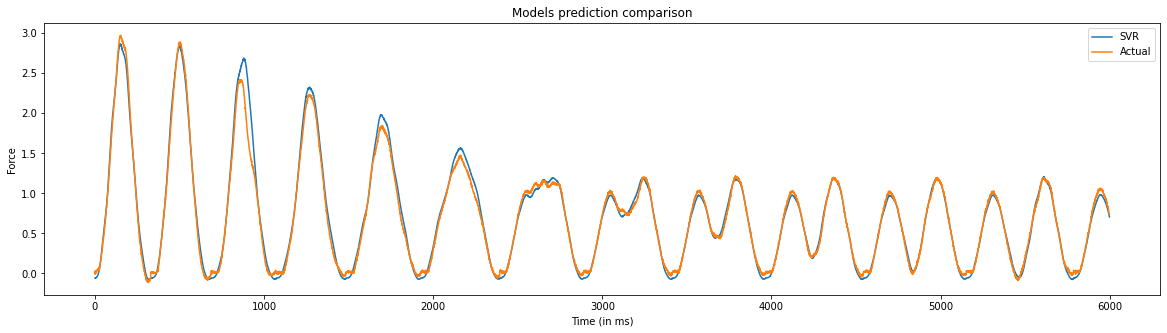

In [10]:
# SVR MODEL
if __name__ == '__main__':
    t1 = datetime.now()
    clf = SVR()
    clf.fit(x_train,y_train)
    t2 = datetime.now()

    print('\n\nTime taken by SVR Model: ',t2-t1)
    y1_pred = clf.predict(x_test)
    y4 = y1_pred
    print('Root mean square error of SVR Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error7 = []
    for i in range(len(y_test)):
        error7.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error7))
    print('Maximum Error =',max(error7))
    error8 = sorted(error7)
    print('Median Value of Error =',error8[len(error8)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y4[:6000], label = 'SVR')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()

# Velocity and Filtered Velocity Plots

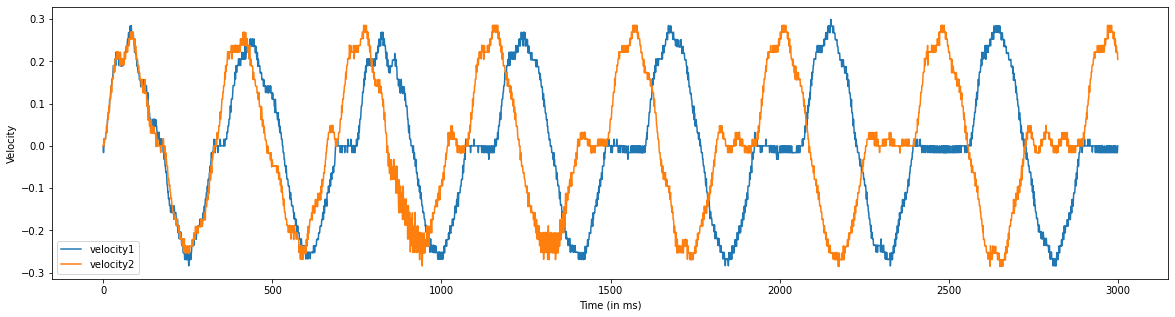

In [13]:
plt.figure(figsize=(20,5))
plt.plot(list(range(3000)),v1_train[:3000], label = 'velocity1')
plt.plot(list(range(3000)),v2_train[:3000], label = 'velocity2')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Velocity')
plt.show()

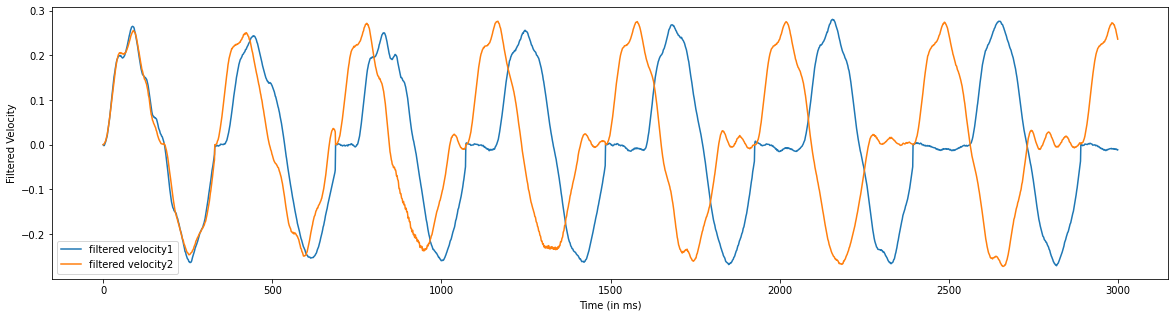

In [14]:
plt.figure(figsize=(20,5))
plt.plot(list(range(3000)),fv1_train[:3000], label = 'filtered velocity1')
plt.plot(list(range(3000)),fv2_train[:3000], label = 'filtered velocity2')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Filtered Velocity')
plt.show()